##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

       0/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 4202496/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

18169856/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

25174016/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

37715968/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

50946048/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

66322432/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

2024-06-27 01:22:05.112570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


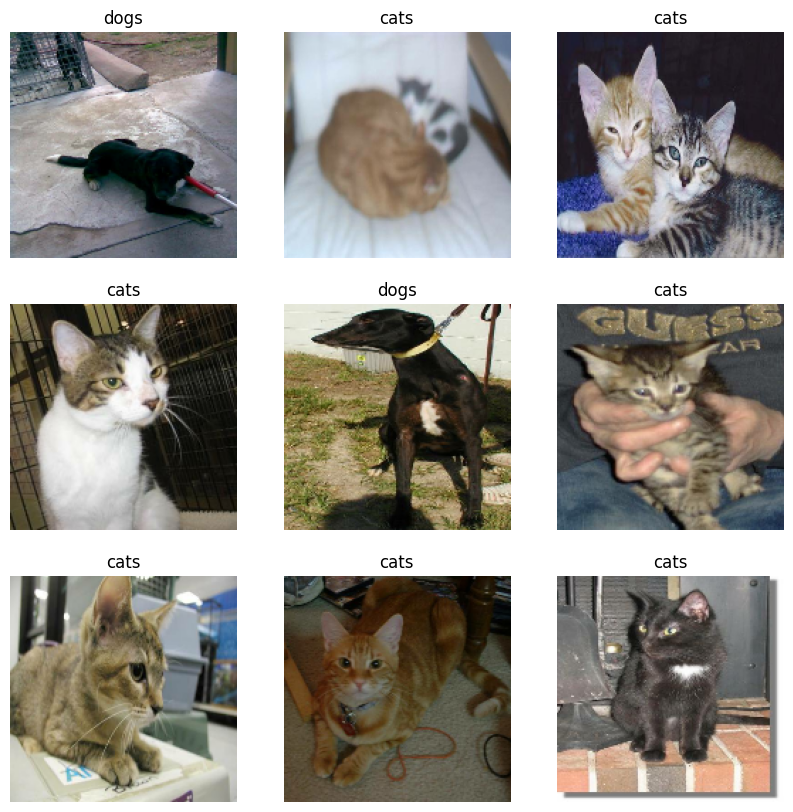

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

2024-06-27 01:22:06.987241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


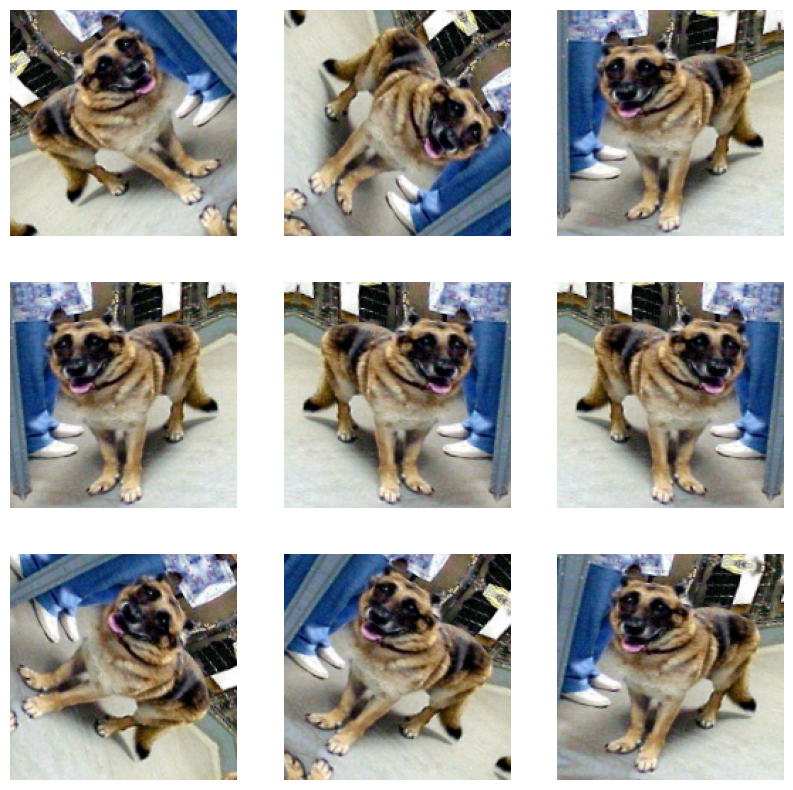

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

      0/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

4784128/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

2

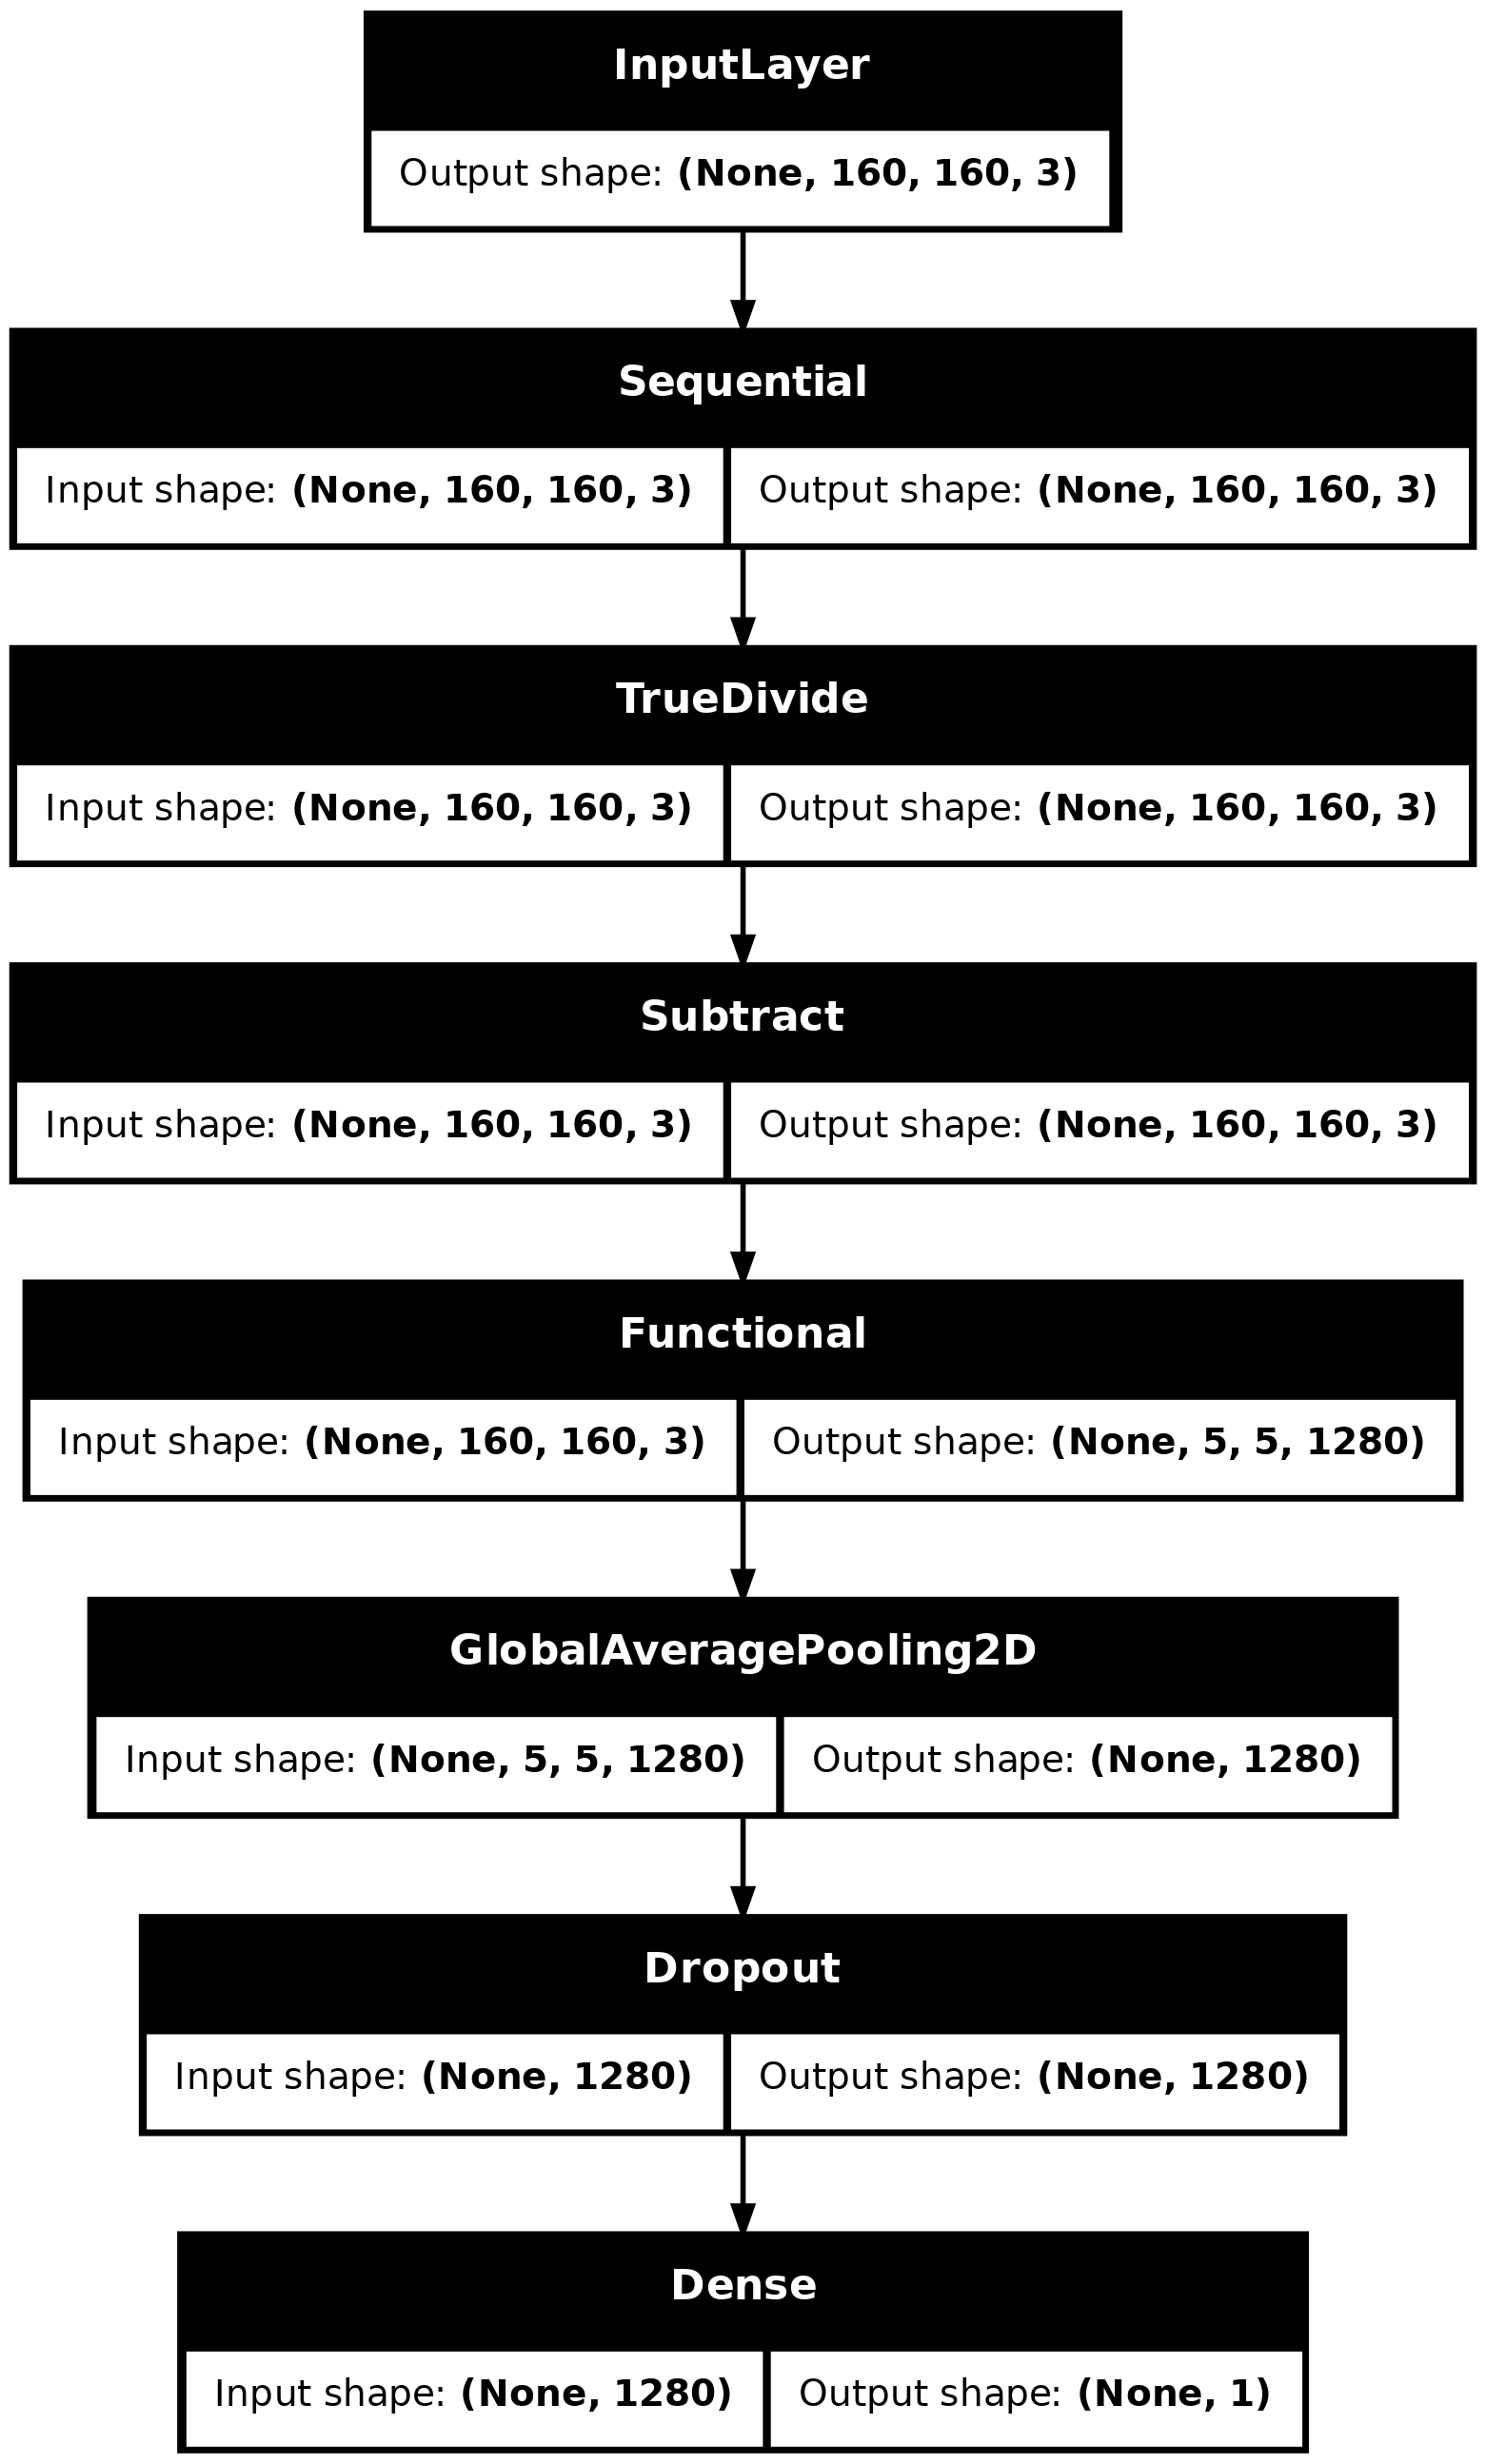

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5312 - loss: 0.8026

 3/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5538 - loss: 0.7661

 5/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5492 - loss: 0.7623

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5468 - loss: 0.7606

 9/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5449 - loss: 0.7582

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5438 - loss: 0.7552

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5432 - loss: 0.7540

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5431 - loss: 0.7505

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5438 - loss: 0.7462

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5447 - loss: 0.7434

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5461 - loss: 0.7413

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5477 - loss: 0.7394

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5492 - loss: 0.7380

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5509 - loss: 0.7364

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5516 - loss: 0.7358


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.57


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 5:04 5s/step - accuracy: 0.5625 - loss: 0.7870

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5938 - loss: 0.7153

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5984 - loss: 0.7000

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5859 - loss: 0.7090

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5786 - loss: 0.7147

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5762 - loss: 0.7161

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5751 - loss: 0.7162

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5744 - loss: 0.7155

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5747 - loss: 0.7142

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5758 - loss: 0.7125

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5773 - loss: 0.7110

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5790 - loss: 0.7093

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5804 - loss: 0.7076

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5821 - loss: 0.7056

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5837 - loss: 0.7036

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5853 - loss: 0.7019

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5871 - loss: 0.7002

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5888 - loss: 0.6985

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5905 - loss: 0.6967

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5920 - loss: 0.6951

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5936 - loss: 0.6936

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5950 - loss: 0.6922

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5964 - loss: 0.6908

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5978 - loss: 0.6895

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5991 - loss: 0.6883

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6004 - loss: 0.6871

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6018 - loss: 0.6858

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6032 - loss: 0.6844

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6045 - loss: 0.6829

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6057 - loss: 0.6815

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6070 - loss: 0.6802

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6082 - loss: 0.6788

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.6088 - loss: 0.6782 - val_accuracy: 0.7908 - val_loss: 0.4953


Epoch 2/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7500 - loss: 0.5600

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7743 - loss: 0.5354

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7730 - loss: 0.5255

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7660 - loss: 0.5254

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7620 - loss: 0.5273

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7601 - loss: 0.5267

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7587 - loss: 0.5261

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7590 - loss: 0.5246

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7583 - loss: 0.5242

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7582 - loss: 0.5235

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7588 - loss: 0.5221

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7591 - loss: 0.5209

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7589 - loss: 0.5201

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7589 - loss: 0.5194

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7585 - loss: 0.5189

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7587 - loss: 0.5180

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7587 - loss: 0.5174

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7588 - loss: 0.5167

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7590 - loss: 0.5161

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7592 - loss: 0.5153

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7594 - loss: 0.5145

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7596 - loss: 0.5139

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7599 - loss: 0.5130

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7603 - loss: 0.5122

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7607 - loss: 0.5113

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7612 - loss: 0.5104

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7617 - loss: 0.5097

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7622 - loss: 0.5088

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7628 - loss: 0.5080

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7634 - loss: 0.5072

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7639 - loss: 0.5064

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7647 - loss: 0.5053 - val_accuracy: 0.8812 - val_loss: 0.3665


Epoch 3/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7812 - loss: 0.4439

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7760 - loss: 0.4525

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7794 - loss: 0.4671

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7838 - loss: 0.4725

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7902 - loss: 0.4703

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7945 - loss: 0.4673

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7963 - loss: 0.4644

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7979 - loss: 0.4614

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7986 - loss: 0.4587

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7992 - loss: 0.4565

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7994 - loss: 0.4547

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7996 - loss: 0.4534

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8001 - loss: 0.4516

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8008 - loss: 0.4496

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8019 - loss: 0.4474

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8028 - loss: 0.4454

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8038 - loss: 0.4435

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8048 - loss: 0.4416

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8059 - loss: 0.4399

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8071 - loss: 0.4381

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8084 - loss: 0.4365

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8094 - loss: 0.4350

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8105 - loss: 0.4336

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8117 - loss: 0.4322

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8127 - loss: 0.4308

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8137 - loss: 0.4296

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8146 - loss: 0.4284

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8154 - loss: 0.4274

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8162 - loss: 0.4263

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8169 - loss: 0.4253

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8177 - loss: 0.4243

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8187 - loss: 0.4228 - val_accuracy: 0.9109 - val_loss: 0.2960


Epoch 4/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8438 - loss: 0.3977

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8316 - loss: 0.3952

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8249 - loss: 0.4039

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8254 - loss: 0.4011

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8278 - loss: 0.3972

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8302 - loss: 0.3958

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8332 - loss: 0.3925

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8360 - loss: 0.3890

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8386 - loss: 0.3863

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8417 - loss: 0.3826

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8445 - loss: 0.3790

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8466 - loss: 0.3760

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8481 - loss: 0.3737

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8493 - loss: 0.3717

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8503 - loss: 0.3698

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8509 - loss: 0.3682

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8515 - loss: 0.3667

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8519 - loss: 0.3655

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8521 - loss: 0.3646

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8524 - loss: 0.3638

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8527 - loss: 0.3630

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8529 - loss: 0.3623

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8532 - loss: 0.3618

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8535 - loss: 0.3611

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8539 - loss: 0.3604

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8541 - loss: 0.3599

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8544 - loss: 0.3593

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8547 - loss: 0.3587

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8550 - loss: 0.3582

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8551 - loss: 0.3578

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8553 - loss: 0.3573

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8556 - loss: 0.3566 - val_accuracy: 0.9344 - val_loss: 0.2435


Epoch 5/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9375 - loss: 0.2686

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9062 - loss: 0.3260

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8925 - loss: 0.3415

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8896 - loss: 0.3387

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8876 - loss: 0.3364

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8861 - loss: 0.3346

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8859 - loss: 0.3327

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8863 - loss: 0.3304

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8874 - loss: 0.3278

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8878 - loss: 0.3258

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8882 - loss: 0.3238

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8885 - loss: 0.3218

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8887 - loss: 0.3202

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8889 - loss: 0.3189

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8892 - loss: 0.3175

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8894 - loss: 0.3164

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8894 - loss: 0.3157

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8895 - loss: 0.3148

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8895 - loss: 0.3140

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8895 - loss: 0.3130

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8895 - loss: 0.3123

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8894 - loss: 0.3117

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8892 - loss: 0.3113

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8890 - loss: 0.3108

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8889 - loss: 0.3103

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8887 - loss: 0.3100

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8885 - loss: 0.3097

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8884 - loss: 0.3093

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8882 - loss: 0.3091

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8880 - loss: 0.3089

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8879 - loss: 0.3085

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8878 - loss: 0.3080 - val_accuracy: 0.9455 - val_loss: 0.2101


Epoch 6/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9062 - loss: 0.2581

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8767 - loss: 0.2786

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8770 - loss: 0.2732

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8772 - loss: 0.2774

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8775 - loss: 0.2795

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8776 - loss: 0.2820

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8787 - loss: 0.2825

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8796 - loss: 0.2829

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8806 - loss: 0.2830

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8811 - loss: 0.2829

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8816 - loss: 0.2827

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8819 - loss: 0.2824

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8826 - loss: 0.2819

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8829 - loss: 0.2816

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8831 - loss: 0.2812

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8832 - loss: 0.2810

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8833 - loss: 0.2809

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8836 - loss: 0.2808

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8838 - loss: 0.2808

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8841 - loss: 0.2807

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8844 - loss: 0.2807

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8847 - loss: 0.2807

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8849 - loss: 0.2806

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8853 - loss: 0.2806

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8856 - loss: 0.2805

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8860 - loss: 0.2804

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8863 - loss: 0.2803

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8866 - loss: 0.2801

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8870 - loss: 0.2798

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8873 - loss: 0.2795

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8876 - loss: 0.2793

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8879 - loss: 0.2790 - val_accuracy: 0.9480 - val_loss: 0.1879


Epoch 7/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9375 - loss: 0.2606

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9132 - loss: 0.2786

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9020 - loss: 0.2844

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8993 - loss: 0.2815

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8951 - loss: 0.2820

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8934 - loss: 0.2811

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8915 - loss: 0.2801

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8902 - loss: 0.2793

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8889 - loss: 0.2791

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8883 - loss: 0.2782

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8882 - loss: 0.2770

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8887 - loss: 0.2753

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8891 - loss: 0.2743

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8898 - loss: 0.2734

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8904 - loss: 0.2727

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8906 - loss: 0.2723

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8908 - loss: 0.2721

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8912 - loss: 0.2717

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8918 - loss: 0.2710

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8923 - loss: 0.2703

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8928 - loss: 0.2695

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8933 - loss: 0.2688

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8938 - loss: 0.2680

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8944 - loss: 0.2672

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8948 - loss: 0.2664

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8953 - loss: 0.2657

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8957 - loss: 0.2651

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8960 - loss: 0.2645

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8963 - loss: 0.2639

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8965 - loss: 0.2634

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8968 - loss: 0.2628

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8970 - loss: 0.2621 - val_accuracy: 0.9554 - val_loss: 0.1616


Epoch 8/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9375 - loss: 0.2365

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9132 - loss: 0.2595

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9145 - loss: 0.2506

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9141 - loss: 0.2489

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9173 - loss: 0.2420

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9172 - loss: 0.2403

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9155 - loss: 0.2392

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9144 - loss: 0.2378

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9139 - loss: 0.2367

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9137 - loss: 0.2357

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9136 - loss: 0.2347

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9132 - loss: 0.2344

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9129 - loss: 0.2340

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9125 - loss: 0.2339

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9122 - loss: 0.2339

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9118 - loss: 0.2341

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9115 - loss: 0.2342

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9112 - loss: 0.2344

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9108 - loss: 0.2347

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9105 - loss: 0.2348

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9102 - loss: 0.2350

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9098 - loss: 0.2351

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9095 - loss: 0.2353

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9092 - loss: 0.2354

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9089 - loss: 0.2355

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9087 - loss: 0.2356

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9086 - loss: 0.2356

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9085 - loss: 0.2355

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9084 - loss: 0.2355

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9083 - loss: 0.2355

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9083 - loss: 0.2354

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9082 - loss: 0.2352 - val_accuracy: 0.9641 - val_loss: 0.1485


Epoch 9/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9375 - loss: 0.2016

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9323 - loss: 0.2051

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9259 - loss: 0.2097

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9202 - loss: 0.2151

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9183 - loss: 0.2199

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9172 - loss: 0.2223

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9173 - loss: 0.2229

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9167 - loss: 0.2237

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9165 - loss: 0.2238

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9159 - loss: 0.2242

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9154 - loss: 0.2242

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9147 - loss: 0.2246

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9144 - loss: 0.2247

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9143 - loss: 0.2248

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9144 - loss: 0.2248

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9146 - loss: 0.2247

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9149 - loss: 0.2247

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9151 - loss: 0.2246

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9153 - loss: 0.2245

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9155 - loss: 0.2245

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9156 - loss: 0.2246

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9156 - loss: 0.2246

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9158 - loss: 0.2245

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9160 - loss: 0.2243

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9160 - loss: 0.2242

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9161 - loss: 0.2241

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9162 - loss: 0.2241

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9162 - loss: 0.2241

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9163 - loss: 0.2240

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9164 - loss: 0.2238

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9164 - loss: 0.2238

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9162 - loss: 0.2239 - val_accuracy: 0.9678 - val_loss: 0.1360


Epoch 10/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9375 - loss: 0.2389

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9375 - loss: 0.2408

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9319 - loss: 0.2376

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9335 - loss: 0.2296

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9356 - loss: 0.2240

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9341 - loss: 0.2238

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9331 - loss: 0.2238

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9322 - loss: 0.2232

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9316 - loss: 0.2222

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9311 - loss: 0.2213

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9306 - loss: 0.2203

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9303 - loss: 0.2192

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9297 - loss: 0.2185

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9290 - loss: 0.2180

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9284 - loss: 0.2177

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9278 - loss: 0.2176

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9273 - loss: 0.2173

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9269 - loss: 0.2169

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9264 - loss: 0.2166

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9260 - loss: 0.2164

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9255 - loss: 0.2163

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9251 - loss: 0.2162

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9247 - loss: 0.2162

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9243 - loss: 0.2162

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9237 - loss: 0.2165

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9231 - loss: 0.2168

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9226 - loss: 0.2170

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9222 - loss: 0.2173

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9218 - loss: 0.2175

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9214 - loss: 0.2177

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9210 - loss: 0.2179

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9204 - loss: 0.2183 - val_accuracy: 0.9728 - val_loss: 0.1245


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

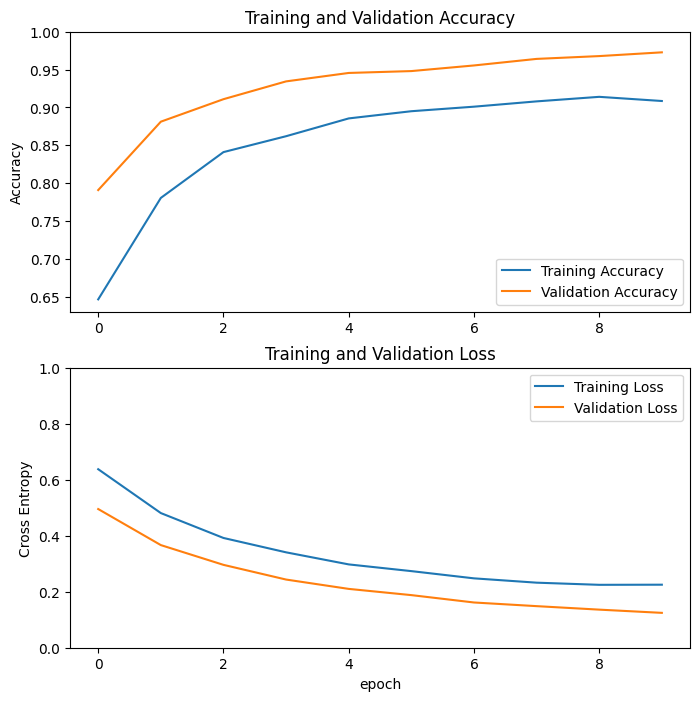

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 9:43 9s/step - accuracy: 0.6875 - loss: 0.6701

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6484 - loss: 0.7021

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6465 - loss: 0.6884

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6492 - loss: 0.6735

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6619 - loss: 0.6486

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6722 - loss: 0.6279

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6816 - loss: 0.6086

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6894 - loss: 0.5927

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6927 - loss: 0.5860

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6954 - loss: 0.5803

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6980 - loss: 0.5748

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7033 - loss: 0.5647

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7059 - loss: 0.5602

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7082 - loss: 0.5559

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7131 - loss: 0.5472

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7154 - loss: 0.5432

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7176 - loss: 0.5394

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7197 - loss: 0.5357

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7220 - loss: 0.5319

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7242 - loss: 0.5284

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7262 - loss: 0.5250

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7303 - loss: 0.5185

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7338 - loss: 0.5126

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7371 - loss: 0.5071

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7403 - loss: 0.5018

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7418 - loss: 0.4994

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7447 - loss: 0.4946

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7476 - loss: 0.4902

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7490 - loss: 0.4880

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7503 - loss: 0.4859

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7529 - loss: 0.4820

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7554 - loss: 0.4782

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7565 - loss: 0.4765

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7587 - loss: 0.4731

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7608 - loss: 0.4699

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7618 - loss: 0.4684

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7638 - loss: 0.4654

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7657 - loss: 0.4624

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7675 - loss: 0.4597

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7693 - loss: 0.4570

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7702 - loss: 0.4557

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.7710 - loss: 0.4544 - val_accuracy: 0.9740 - val_loss: 0.0892


Epoch 12/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8750 - loss: 0.2662

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8750 - loss: 0.2727

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8785 - loss: 0.2734

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8737 - loss: 0.2797

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8684 - loss: 0.2927

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8648 - loss: 0.3004

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8638 - loss: 0.3014

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8636 - loss: 0.3018

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8640 - loss: 0.3015

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8643 - loss: 0.3014

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8651 - loss: 0.3007

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8660 - loss: 0.3000

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8665 - loss: 0.2997

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8672 - loss: 0.2996

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8671 - loss: 0.3001

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8670 - loss: 0.3003

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8671 - loss: 0.3004

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8674 - loss: 0.3003

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8677 - loss: 0.3000

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8688 - loss: 0.2988

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8697 - loss: 0.2978

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8705 - loss: 0.2968

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8713 - loss: 0.2957

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8721 - loss: 0.2946

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8729 - loss: 0.2935

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8739 - loss: 0.2923

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8746 - loss: 0.2914

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8754 - loss: 0.2903

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8762 - loss: 0.2892

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8770 - loss: 0.2881

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8777 - loss: 0.2869

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8784 - loss: 0.2858

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8788 - loss: 0.2852

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8795 - loss: 0.2840

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8802 - loss: 0.2830

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8806 - loss: 0.2825

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8812 - loss: 0.2815

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8818 - loss: 0.2805

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8824 - loss: 0.2796

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8829 - loss: 0.2787 - val_accuracy: 0.9752 - val_loss: 0.0771


Epoch 13/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9375 - loss: 0.2397

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8906 - loss: 0.3099

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8861 - loss: 0.3119

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8914 - loss: 0.3008

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8957 - loss: 0.2861

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8984 - loss: 0.2750

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9010 - loss: 0.2666

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9018 - loss: 0.2637

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9030 - loss: 0.2585

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9033 - loss: 0.2546

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9039 - loss: 0.2512

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9044 - loss: 0.2483

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9049 - loss: 0.2458

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9054 - loss: 0.2438

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9056 - loss: 0.2422

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9058 - loss: 0.2409

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9062 - loss: 0.2395

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9066 - loss: 0.2383

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9070 - loss: 0.2370

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9071 - loss: 0.2365

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9074 - loss: 0.2355

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9077 - loss: 0.2345

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9080 - loss: 0.2336

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9081 - loss: 0.2330

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9082 - loss: 0.2326

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9084 - loss: 0.2322

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9086 - loss: 0.2314

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9089 - loss: 0.2307

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9090 - loss: 0.2302

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9091 - loss: 0.2297

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9092 - loss: 0.2292

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9093 - loss: 0.2286

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9094 - loss: 0.2281

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9096 - loss: 0.2275

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9097 - loss: 0.2270

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9097 - loss: 0.2267 - val_accuracy: 0.9802 - val_loss: 0.0603


Epoch 14/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7500 - loss: 0.3773

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7969 - loss: 0.3206

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8229 - loss: 0.2927

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8531 - loss: 0.2636

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8637 - loss: 0.2526

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8751 - loss: 0.2469

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8810 - loss: 0.2468

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8833 - loss: 0.2460

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8872 - loss: 0.2443

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8886 - loss: 0.2439

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8918 - loss: 0.2417

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8949 - loss: 0.2392

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8976 - loss: 0.2366

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8989 - loss: 0.2352

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9002 - loss: 0.2340

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9022 - loss: 0.2316

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9038 - loss: 0.2296

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9053 - loss: 0.2277

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9068 - loss: 0.2258

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9080 - loss: 0.2243

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9091 - loss: 0.2229

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9101 - loss: 0.2217

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9109 - loss: 0.2206

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9117 - loss: 0.2195

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9123 - loss: 0.2186

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9130 - loss: 0.2176

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9133 - loss: 0.2171

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9140 - loss: 0.2161

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9143 - loss: 0.2156

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9147 - loss: 0.2151

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9152 - loss: 0.2141

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9158 - loss: 0.2132

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9164 - loss: 0.2124

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9168 - loss: 0.2117

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9173 - loss: 0.2110

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9178 - loss: 0.2103

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9183 - loss: 0.2095

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9186 - loss: 0.2091 - val_accuracy: 0.9827 - val_loss: 0.0577


Epoch 15/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9062 - loss: 0.2545

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9141 - loss: 0.2317

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9245 - loss: 0.2048

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9168 - loss: 0.2091

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9070 - loss: 0.2210

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9019 - loss: 0.2270

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8989 - loss: 0.2305

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8967 - loss: 0.2334

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8965 - loss: 0.2335

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8959 - loss: 0.2342

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8963 - loss: 0.2334

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8966 - loss: 0.2322

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8973 - loss: 0.2304

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8976 - loss: 0.2293

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8982 - loss: 0.2273

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8991 - loss: 0.2249

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9000 - loss: 0.2227

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9010 - loss: 0.2206

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9021 - loss: 0.2183

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9031 - loss: 0.2161

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9041 - loss: 0.2141

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9049 - loss: 0.2125

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9057 - loss: 0.2109

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9065 - loss: 0.2094

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9071 - loss: 0.2081

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9074 - loss: 0.2074

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9080 - loss: 0.2062

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9086 - loss: 0.2050

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9091 - loss: 0.2038

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9095 - loss: 0.2028

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9100 - loss: 0.2018

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9104 - loss: 0.2008

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9108 - loss: 0.1999

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9112 - loss: 0.1990

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9116 - loss: 0.1982

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9118 - loss: 0.1978 - val_accuracy: 0.9814 - val_loss: 0.0553


Epoch 16/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8125 - loss: 0.4498

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8438 - loss: 0.3858

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8789 - loss: 0.3140

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8894 - loss: 0.2920

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9044 - loss: 0.2597

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9130 - loss: 0.2395

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9185 - loss: 0.2259

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9216 - loss: 0.2169

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9243 - loss: 0.2099

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9254 - loss: 0.2069

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9272 - loss: 0.2015

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9287 - loss: 0.1969

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9294 - loss: 0.1949

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9306 - loss: 0.1913

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9311 - loss: 0.1897

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9322 - loss: 0.1868

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9331 - loss: 0.1841

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9335 - loss: 0.1829

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9342 - loss: 0.1807

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9348 - loss: 0.1786

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9351 - loss: 0.1771

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9352 - loss: 0.1764

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9355 - loss: 0.1750

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9358 - loss: 0.1738

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9361 - loss: 0.1726

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9364 - loss: 0.1714

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9367 - loss: 0.1703

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9369 - loss: 0.1697

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9372 - loss: 0.1687

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9373 - loss: 0.1683

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9375 - loss: 0.1675

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9377 - loss: 0.1666

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9379 - loss: 0.1658

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9380 - loss: 0.1655

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9381 - loss: 0.1649

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9382 - loss: 0.1644

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9382 - loss: 0.1639

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9382 - loss: 0.1637 - val_accuracy: 0.9839 - val_loss: 0.0507


Epoch 17/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9375 - loss: 0.1163

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9358 - loss: 0.1317

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9393 - loss: 0.1372

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9360 - loss: 0.1465

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9335 - loss: 0.1523

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9324 - loss: 0.1545

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9312 - loss: 0.1568

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9308 - loss: 0.1577

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9305 - loss: 0.1580

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9302 - loss: 0.1583

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9301 - loss: 0.1584

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9297 - loss: 0.1583

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9292 - loss: 0.1583

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9287 - loss: 0.1583

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9285 - loss: 0.1582

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9284 - loss: 0.1580

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9285 - loss: 0.1576

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9285 - loss: 0.1576

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9285 - loss: 0.1575

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9286 - loss: 0.1573

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9288 - loss: 0.1570

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9290 - loss: 0.1567

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9290 - loss: 0.1565

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9293 - loss: 0.1560

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9296 - loss: 0.1555

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9300 - loss: 0.1549

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9301 - loss: 0.1546

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9304 - loss: 0.1542

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9307 - loss: 0.1538

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9309 - loss: 0.1534

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9313 - loss: 0.1529

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9314 - loss: 0.1527

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9317 - loss: 0.1524

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9320 - loss: 0.1520

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9322 - loss: 0.1517

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9325 - loss: 0.1515 - val_accuracy: 0.9827 - val_loss: 0.0502


Epoch 18/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9375 - loss: 0.1309

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9375 - loss: 0.1302

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9410 - loss: 0.1228

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9468 - loss: 0.1242

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9461 - loss: 0.1283

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9450 - loss: 0.1313

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9442 - loss: 0.1326

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9432 - loss: 0.1342

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9427 - loss: 0.1349

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9419 - loss: 0.1358

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9417 - loss: 0.1363

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9417 - loss: 0.1362

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9417 - loss: 0.1360

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9417 - loss: 0.1362

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9419 - loss: 0.1360

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9422 - loss: 0.1354

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9425 - loss: 0.1350

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9426 - loss: 0.1349

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9428 - loss: 0.1348

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9429 - loss: 0.1349

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9430 - loss: 0.1349

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9429 - loss: 0.1352

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9429 - loss: 0.1354

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9429 - loss: 0.1355

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9430 - loss: 0.1355

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9430 - loss: 0.1355

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9431 - loss: 0.1354

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9431 - loss: 0.1353

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9432 - loss: 0.1352

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9434 - loss: 0.1351

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9435 - loss: 0.1350

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9437 - loss: 0.1349

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9439 - loss: 0.1348

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9441 - loss: 0.1347

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9443 - loss: 0.1345

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9444 - loss: 0.1343

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9446 - loss: 0.1341

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9448 - loss: 0.1339 - val_accuracy: 0.9827 - val_loss: 0.0511


Epoch 19/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9375 - loss: 0.1122

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9453 - loss: 0.1084

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9499 - loss: 0.1091

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9543 - loss: 0.1081

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9549 - loss: 0.1111

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9541 - loss: 0.1140

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9537 - loss: 0.1155

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9533 - loss: 0.1180

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9532 - loss: 0.1193

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9535 - loss: 0.1194

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9541 - loss: 0.1189

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9544 - loss: 0.1186

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9546 - loss: 0.1181

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9547 - loss: 0.1177

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9547 - loss: 0.1178

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9545 - loss: 0.1185

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9543 - loss: 0.1192

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9542 - loss: 0.1195

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9541 - loss: 0.1200

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9540 - loss: 0.1202

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9539 - loss: 0.1205

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9537 - loss: 0.1209

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9535 - loss: 0.1211

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9534 - loss: 0.1212

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9533 - loss: 0.1213

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9533 - loss: 0.1213

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9533 - loss: 0.1214

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9532 - loss: 0.1214

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9533 - loss: 0.1214

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9533 - loss: 0.1214

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9532 - loss: 0.1215

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9532 - loss: 0.1215

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9533 - loss: 0.1214

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9533 - loss: 0.1214

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9534 - loss: 0.1214

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9534 - loss: 0.1213 - val_accuracy: 0.9827 - val_loss: 0.0470


Epoch 20/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9375 - loss: 0.1355

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9453 - loss: 0.1289

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9570 - loss: 0.1151

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9533 - loss: 0.1212

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9520 - loss: 0.1252

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9494 - loss: 0.1304

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9461 - loss: 0.1376

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9439 - loss: 0.1429

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9429 - loss: 0.1452

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9426 - loss: 0.1462

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9428 - loss: 0.1462

22/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9430 - loss: 0.1463

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9432 - loss: 0.1462

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9433 - loss: 0.1462

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9434 - loss: 0.1462

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9434 - loss: 0.1463

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9434 - loss: 0.1464

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9435 - loss: 0.1465

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9437 - loss: 0.1465

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9438 - loss: 0.1464

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9439 - loss: 0.1463

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9440 - loss: 0.1460

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9442 - loss: 0.1456

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9443 - loss: 0.1455

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9443 - loss: 0.1455

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9445 - loss: 0.1452

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9446 - loss: 0.1449

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9447 - loss: 0.1446

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9449 - loss: 0.1442

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9450 - loss: 0.1437

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9452 - loss: 0.1432

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9454 - loss: 0.1427

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9457 - loss: 0.1423

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9458 - loss: 0.1421

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9460 - loss: 0.1416

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9463 - loss: 0.1412

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9464 - loss: 0.1408

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9465 - loss: 0.1408 - val_accuracy: 0.9827 - val_loss: 0.0466


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

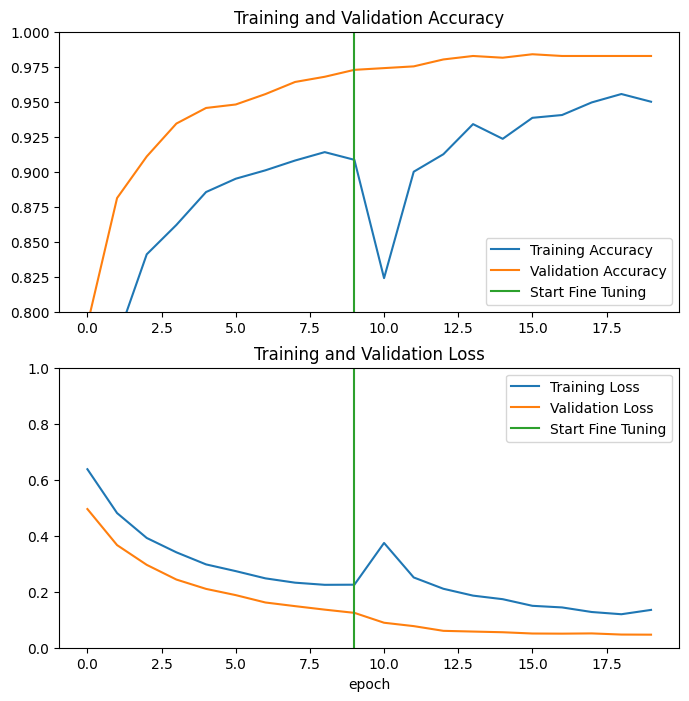

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0292

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9913 - loss: 0.0376

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9892 - loss: 0.0360

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9893 - loss: 0.0340


Test accuracy : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0]
Labels:
 [1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0]


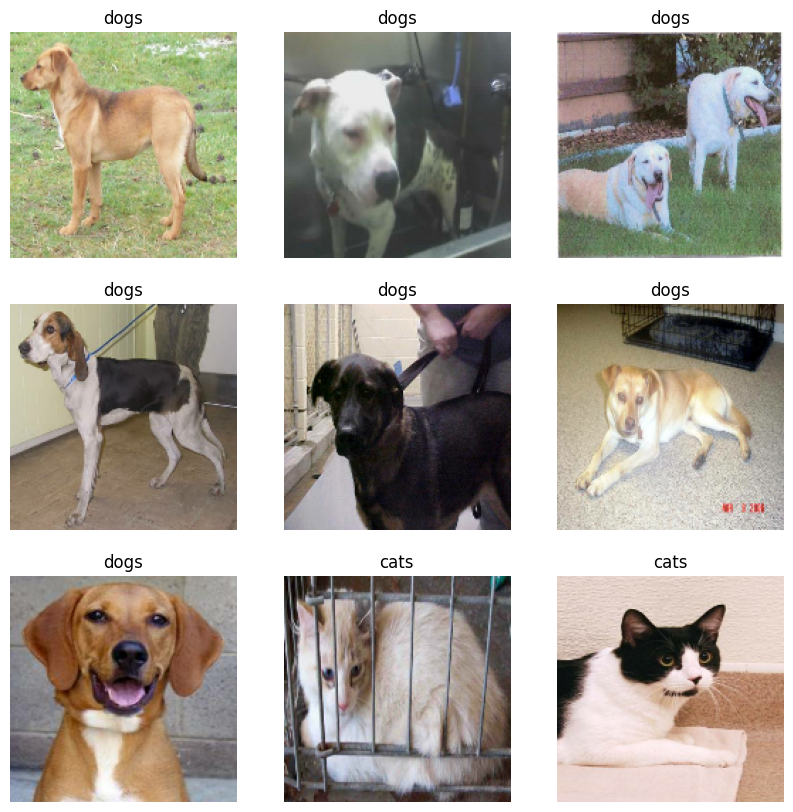

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
